In [1]:
import sys

#sys.path.insert(0, 'backend_functions')

#import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

from matplotlib import gridspec


Welcome to JupyROOT 6.24/02


In [2]:
ending = "Jan19b_MECTune"

In [3]:
##Regular tune prior true and smearcept to be used


#Recall for comparison it will be the MEC tune for prior true

In [4]:
####Load in MECTune full event counts

nue_data_signal = pd.read_csv("nue_full_500_catsel_nopions_angleDiff_usingSelection_full_evt_count_MCONLY_recoCut_comb_"+ending+".csv", header=None)

nue_data_signal = nue_data_signal.values[:, 0]

print(nue_data_signal)
print("")

######

numu_data_signal = pd.read_csv("numu_full_500_catsel_nopions_angleDiff_usingSelection_full_evt_count_MCONLY_recoCut_comb_"+ending+".csv", header=None)

numu_data_signal = numu_data_signal.values[:, 0]

print(numu_data_signal)

[  2.41894388   3.37036459   4.0676717    8.73306979   9.6886565
  11.01616168  14.78698607  25.91226471  52.24230196 151.27904718]

[  56.48216733   44.43568557   60.05517969   76.89967273   87.50709933
  150.27116984  201.76475939  325.45525751  603.17700026 1185.10352493]


In [5]:
###Load in regular tune bkg event counts
#Include ext in bkg count here as the full event counts do

ending = "Jan19b" #need this ending as bkg is from regular tune



nue_bkg_inc_ext = pd.read_csv("nue_nopions_angleDiff_usingSelection_comb_cv_nue_bkg_incExt_"+ending+".csv", header=None)

nue_bkg_inc_ext = nue_bkg_inc_ext.values[:, 0]

print(nue_bkg_inc_ext)
print("")

#######################

numu_bkg_inc_ext = pd.read_csv("numu_nopions_angleDiff_usingSelection_comb_cv_numu_bkg_incExt_"+ending+".csv", header=None)

numu_bkg_inc_ext = numu_bkg_inc_ext.values[:, 0]

print(numu_bkg_inc_ext)
print("")

[ 1.12526165  1.34119398  1.9677378   4.85417832  3.56980533  4.03877779
  3.87288048  6.20261081 13.48506183 41.19945679]

[ 21.12417618  13.66555818  12.75149841  13.44984114  18.55950364
  36.54433324  54.24502032  88.85075733 175.76762929 359.07344107]



In [6]:
####So then can calculate the data signal input to the unfolding

nue_datasig_bkg_subtracted = nue_data_signal - nue_bkg_inc_ext
print(nue_datasig_bkg_subtracted)
print("")

numu_datasig_bkg_subtracted = numu_data_signal - numu_bkg_inc_ext
print(numu_datasig_bkg_subtracted)

[  1.29368223   2.02917061   2.09993389   3.87889147   6.11885117
   6.97738388  10.91410559  19.70965391  38.75724012 110.07959039]

[ 35.35799115  30.7701274   47.30368128  63.4498316   68.94759569
 113.7268366  147.51973907 236.60450019 427.40937097 826.03008387]


In [7]:
nue_numu_tot = np.concatenate((nue_datasig_bkg_subtracted, numu_datasig_bkg_subtracted), axis=0)

print(nue_numu_tot)
print(len(nue_numu_tot))

[  1.29368223   2.02917061   2.09993389   3.87889147   6.11885117
   6.97738388  10.91410559  19.70965391  38.75724012 110.07959039
  35.35799115  30.7701274   47.30368128  63.4498316   68.94759569
 113.7268366  147.51973907 236.60450019 427.40937097 826.03008387]
20


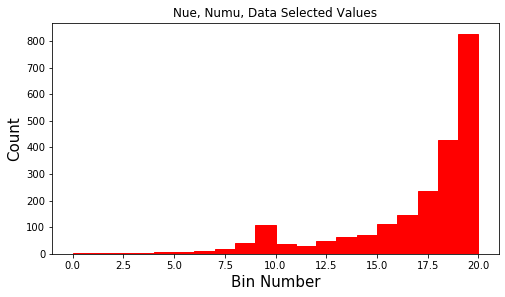

In [8]:
nue_numu_fig = plt.figure(figsize=(8, 7))
nue_numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_numu_ax1 = plt.subplot(nue_numu_gs[0])


#bins = np.arange(0, 10.5, 0.5)
#count = np.linspace(0.1, 9.6, 20)
bins = np.arange(0, 21, 1)
count = np.arange(0.0, 20.0, 1)


sel_ratio = nue_numu_ax1.hist(count, bins, edgecolor='red', facecolor='red', weights=nue_numu_tot)
nue_numu_ax1.set_ylabel('Count', fontsize=15)
nue_numu_ax1.set_xlabel('Bin Number', fontsize=15)
nue_numu_ax1.set_title("Nue, Numu, Data Selected Values")
#leg = nue_numu_ax1.legend()
#nue_numu_ax1.set_ylim([0, 1])

nue_numu_fig.savefig("data_signal_MC_MECTune_input_angleDiff_comb_"+ending+".svg", bbox_inches='tight')

In [9]:
np.savetxt("data_signal_MC_MECTune_input_angleDiff_comb_"+ending+".csv", 
               nue_numu_tot,
               delimiter =", ", 
               fmt ='% s')

print(ending)

Jan19b


In [10]:
####Now need to get in the uncertainties

###First up, get the noTune statistical uncertinaty. This will be from sig + bkg in noTune

ending = "Jan19b_MECTune" 


nue_sig_unc = pd.read_csv("nue_total_noTune_err_squared_angle_comb_"+ending+".csv", header=None)

nue_sig_unc = nue_sig_unc.values[:, 0]

print(nue_sig_unc)
print("")

########################

numu_sig_unc = pd.read_csv("numu_total_noTune_err_squared_angle_comb_"+ending+".csv", header=None)

numu_sig_unc = numu_sig_unc.values[:, 0]

print(numu_sig_unc)
print("")

#######################The regular tune bkg stat uncertainties

ending = "Jan19b" #need this ending as bkg is from regular tune


nue_bkg_unc = pd.read_csv("nue_bkg_exp_err_squared_angle_comb_"+ending+".csv", header=None)

nue_bkg_unc = nue_bkg_unc.values[:, 0]

print(nue_bkg_unc)
print("")

########################

numu_bkg_unc = pd.read_csv("numu_bkg_exp_err_squared_angle_comb_"+ending+".csv", header=None)

numu_bkg_unc = numu_bkg_unc.values[:, 0]

print(numu_bkg_unc)
print("")

[ 0.4925286   0.42828642  1.1622193   2.17086629  1.34583324  1.67560586
  1.33402357  2.22384029  9.01828919 17.06002461]

[  16.96402979   11.14391331   22.43145178   34.34873736   27.20022368
  115.46394527  119.88525242  228.96574026  507.69041624 1452.13922179]

[0.40397591 0.37808445 1.0941558  1.8814619  1.1171987  1.52658216
 0.90694911 1.11480065 2.80841077 5.50815593]

[ 5.45466702  3.33918978  4.99445026  3.95957698  6.36767205 16.47824989
 23.04967856 32.79183015 56.30092691 96.5522802 ]



In [11]:
nue_stat_unc = nue_sig_unc + nue_bkg_unc
print(nue_stat_unc)
print("")

########################

numu_stat_unc = numu_sig_unc + numu_bkg_unc
print(numu_stat_unc)
print("")

#########################

nue_numu_tot_unc = np.concatenate((nue_stat_unc, numu_stat_unc), axis=0)

print(nue_numu_tot_unc)

[ 0.89650451  0.80637087  2.2563751   4.0523282   2.46303195  3.20218802
  2.24097268  3.33864095 11.82669996 22.56818054]

[  22.41869681   14.48310309   27.42590204   38.30831434   33.56789574
  131.94219516  142.93493099  261.75757041  563.99134315 1548.69150198]

[8.96504506e-01 8.06370869e-01 2.25637510e+00 4.05232820e+00
 2.46303195e+00 3.20218802e+00 2.24097268e+00 3.33864095e+00
 1.18267000e+01 2.25681805e+01 2.24186968e+01 1.44831031e+01
 2.74259020e+01 3.83083143e+01 3.35678957e+01 1.31942195e+02
 1.42934931e+02 2.61757570e+02 5.63991343e+02 1.54869150e+03]


In [12]:
nue_numu_cov_stats   = np.zeros([(len(bins)-1), (len(bins)-1)])
print(nue_numu_cov_stats)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [13]:
nue_numu_cov_stats[np.diag_indices_from(nue_numu_cov_stats)]    = nue_numu_tot_unc

In [14]:
###Then sprinkle in the regular tune genie sys uncertainties

# Load in the blockwise genie cov matrix

blockwise_genie_err = pd.read_csv("blockwise_cov_genie_only_angle_comb_"+ending+".csv", header=None)

blockwise_genie_err = blockwise_genie_err.values
print(blockwise_genie_err)

[[ 9.18443116e-02  1.13662907e-01  8.33358093e-02  2.10837354e-01
   2.07396226e-01  2.59818023e-01  3.27722256e-01  6.27585065e-01
   1.28768475e+00  3.50560204e+00  1.38008040e+00  9.40463478e-01
   1.25984605e+00  1.62055443e+00  1.54775410e+00  3.03943943e+00
   4.21961010e+00  6.83774612e+00  1.34303165e+01  2.65512195e+01]
 [ 1.13662907e-01  2.33863420e-01  1.39791193e-01  3.34271316e-01
   3.24597457e-01  4.54591883e-01  5.47101848e-01  9.87749872e-01
   1.88414592e+00  4.29363595e+00  2.31316165e+00  1.75279186e+00
   2.28451225e+00  2.85667393e+00  2.89229148e+00  4.68332834e+00
   6.23796707e+00  9.60210418e+00  1.81233648e+01  3.08530459e+01]
 [ 8.33358093e-02  1.39791193e-01  1.66734039e-01  2.88419853e-01
   2.64217900e-01  3.76454316e-01  5.23566839e-01  9.52845690e-01
   1.99534694e+00  5.73646958e+00  1.79901108e+00  1.33805924e+00
   2.00791801e+00  2.65311693e+00  2.53738796e+00  4.89447117e+00
   6.48096814e+00  1.04324050e+01  2.12042649e+01  4.37035809e+01]
 [ 2.10

In [15]:
# Load in the blockwise nuwrounisim cov matrix

nuWro_unisim = pd.read_csv("nuWro_extra_unisim_uncertainties_angle_comb_"+ending+".csv", header=None)

nuWro_unisim = nuWro_unisim.values
print(nuWro_unisim)

[[ 2.66764082e+00 -1.92007286e+00 -4.11136801e-01  1.28835472e+00
  -2.80741383e+00 -4.49351472e+00  1.99695134e+00 -5.47084551e+00
   1.89244860e-01  2.64680810e+01  3.52803426e+00 -3.00908718e+01
  -4.16891534e+01 -1.69118695e+00 -7.39455414e+00 -4.97564616e+01
  -5.97663340e+00 -5.92124514e+01  8.98624927e+00  8.14334332e+01]
 [-1.92007286e+00  1.38200007e+00  2.95921628e-01 -9.27311847e-01
   2.02067650e+00  3.23427186e+00 -1.43733446e+00  3.93771977e+00
  -1.36211711e-01 -1.90507821e+01 -2.53935341e+00  2.16583379e+01
   3.00063679e+01  1.21725614e+00  5.32233672e+00  3.58129291e+01
   4.30176787e+00  4.26190138e+01 -6.46798220e+00 -5.86128851e+01]
 [-4.11136801e-01  2.95921628e-01  6.33644034e-02 -1.98561229e-01
   4.32678617e-01  6.92540484e-01 -3.07770139e-01  8.43166705e-01
  -2.91664176e-02 -4.07926061e+00 -5.43740636e-01  4.63760513e+00
   6.42513228e+00  2.60645731e-01  1.13964868e+00  7.66846581e+00
   9.21118734e-01  9.12582296e+00 -1.38496073e+00 -1.25505207e+01]
 [ 1.28

In [16]:
##### Now make the total cov matrix

total_noTune_input_cov = nue_numu_cov_stats + blockwise_genie_err + nuWro_unisim

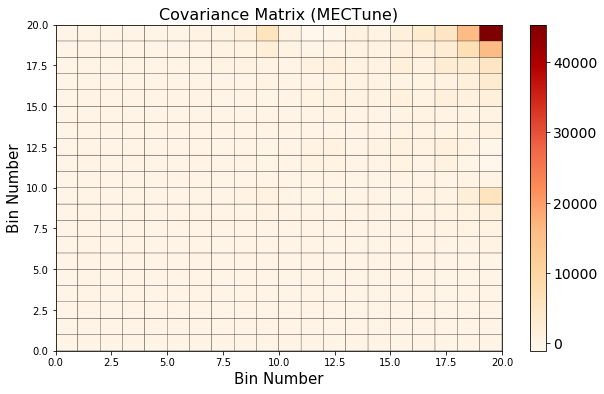

In [17]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, total_noTune_input_cov, cmap='OrRd', edgecolors='k')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
#if pot: 
#    cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

plt.xlim(bins[0], bins[-1])
plt.ylim(bins[0], bins[-1])


plt.xlabel("Bin Number", fontsize=15)
plt.ylabel("Bin Number", fontsize=15)

plt.title('Covariance Matrix (MECTune)', fontsize=16)


plt.savefig("data_covmat_MC_MECTune_input_angleDiff_comb_"+ending+".svg", bbox_inches='tight')

plt.show()

In [18]:
np.savetxt("data_covmat_MC_MECTune_input_angleDiff_comb_"+ending+".csv", 
           total_noTune_input_cov,
           delimiter =", ", 
           fmt ='% s')